In [1]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [2]:
!wget --no-check-certificate \
    https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip \
  -O /tmp/rockpaperscissors.zip

--2021-02-06 15:51:50--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘/tmp/rockpaperscissors.zip’

/tmp/rockpapersciss 100%[===================>] 307.92M  1.09MB/s    in 4m 43s  

2021-02-06 15:56:35 (1.09 MB/s) - ‘/tmp/rockpaperscissors.zip’ saved [322873683/322873683]



In [3]:
# melakukan ekstraksi pada file zip
import zipfile, os, shutil
local_zip = '/tmp/rockpaperscissors.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()
  
base_dir = '/tmp/rockpaperscissors/'
image_dir = '/tmp/rockpaperscissors/rps-cv-images'
rock_dir = os.path.join(base_dir, 'rock')
paper_dir = os.path.join(base_dir, 'paper')
scissors_dir = os.path.join(base_dir, 'scissors')

#menghapus file yang tidak diperlukan, menggunakan shutil karena kita akan menghapus directory yang tidak kosong
os.remove(os.path.join(base_dir, 'README_rpc-cv-images.txt'))

In [4]:
#mengecek isi folder
os.listdir('/tmp/rockpaperscissors/')

['rock', 'scissors', 'rps-cv-images', 'paper']

In [5]:
#kita buat variabel untuk directory train dan validation
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

In [6]:
print("Directory untuk train dan validation adalah ", train_dir, "dan", validation_dir)

Directory untuk train dan validation adalah  /tmp/rockpaperscissors/train dan /tmp/rockpaperscissors/val


In [7]:
#sekarang kita akan memecahkan paper, rock, scissors menjadi train set dan validation set menggunakan library split folders
!pip install split_folders

In [8]:
import splitfolders
splitfolders.ratio(image_dir, output = base_dir, seed = 1337,ratio=(0.6,0.4))

Copying files: 2188 files [00:00, 3754.94 files/s]


In [9]:
os.listdir('/tmp/rockpaperscissors/val')#file berhasil tercopy dengan ratio train dan validation 60:40

['rock', 'scissors', 'paper']

In [109]:
from sklearn.model_selection import train_test_split

train_rock, val_rock= train_test_split(os.listdir(rock_dir), test_size=0.4)
train_paper, val_paper= train_test_split(os.listdir(paper_dir), test_size=0.4)
train_scissors, val_scissors= train_test_split(os.listdir(scissors_dir), test_size=0.4)

In [110]:
#buat objek Image Generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255, rotation_range = 20, horizontal_flip = True, shear_range=0.2, fill_mode='nearest') 
test_datagen = ImageDataGenerator(rescale = 1./255, rotation_range = 20, horizontal_flip = True, shear_range=0.2, fill_mode='nearest') 

In [111]:
train_gen = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), batch_size=32, class_mode='categorical')
validation_gen = test_datagen.flow_from_directory(validation_dir, target_size=(150, 150), batch_size=32, class_mode='categorical')

Found 1312 images belonging to 3 classes.
Found 876 images belonging to 3 classes.


In [112]:
#kita buat modelnya
import tensorflow as tf
from keras.layers import LeakyReLU
model = tf.keras.Sequential([
    #input layers
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax'),
])

model.summary()

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_373 (Conv2D)          (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_172 (MaxPoolin (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_374 (Conv2D)          (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_173 (MaxPoolin (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_375 (Conv2D)          (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_174 (MaxPoolin (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_376 (Conv2D)          (None, 15, 15, 128)     

In [113]:
model.compile(loss='categorical_crossentropy', optimizer=tf.optimizers.Adam(), metrics=['accuracy'])

In [114]:
# latih model dengan model.fit dan callbacks
#Referensi: https://towardsdatascience.com/a-practical-introduction-to-keras-callbacks-in-tensorflow-2-705d0c584966
import tensorflow.keras.callbacks as callback

#history = callback.History()
#early_stopping = callback.EarlyStopping(patience=0, monitor='val_loss')

model.fit(
      train_gen,
      steps_per_epoch=5,  
      epochs=20, 
      validation_data=validation_gen, 
      validation_steps=5,  
      verbose=2)

Epoch 1/20
5/5 - 13s - loss: 1.2489 - accuracy: 0.3250 - val_loss: 1.0968 - val_accuracy: 0.3250
Epoch 2/20
5/5 - 12s - loss: 1.1001 - accuracy: 0.3187 - val_loss: 1.0852 - val_accuracy: 0.5875
Epoch 3/20
5/5 - 12s - loss: 1.0871 - accuracy: 0.4187 - val_loss: 1.0738 - val_accuracy: 0.3375
Epoch 4/20
5/5 - 12s - loss: 1.0553 - accuracy: 0.6187 - val_loss: 0.9975 - val_accuracy: 0.6438
Epoch 5/20
5/5 - 12s - loss: 0.9143 - accuracy: 0.5688 - val_loss: 0.7943 - val_accuracy: 0.6938
Epoch 6/20
5/5 - 12s - loss: 0.6004 - accuracy: 0.8625 - val_loss: 0.6249 - val_accuracy: 0.7250
Epoch 7/20
5/5 - 12s - loss: 0.6016 - accuracy: 0.7812 - val_loss: 1.3235 - val_accuracy: 0.5688
Epoch 8/20
5/5 - 12s - loss: 0.6105 - accuracy: 0.7312 - val_loss: 0.7842 - val_accuracy: 0.6750
Epoch 9/20
5/5 - 12s - loss: 0.5997 - accuracy: 0.7375 - val_loss: 0.5901 - val_accuracy: 0.7875
Epoch 10/20
5/5 - 12s - loss: 0.5278 - accuracy: 0.7937 - val_loss: 0.5793 - val_accuracy: 0.7750
Epoch 11/20
5/5 - 12s - loss:

Saving 329306.jpg to 329306.jpg
329306.jpg
Paper


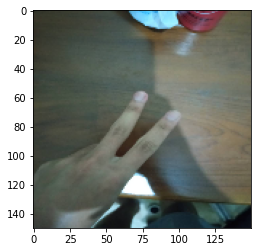

In [123]:
    import numpy as np
    from google.colab import files
    from keras.preprocessing import image
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    %matplotlib inline
     
    uploaded = files.upload()
     
    for fn in uploaded.keys():
     
      # predicting images
      path = fn
      img = image.load_img(path, target_size=(150,150))
      imgplot = plt.imshow(img)
      x = image.img_to_array(img)
      x = np.expand_dims(x, axis=0)
     
      images = np.vstack([x])
      classes = model.predict(images, batch_size=10)
      resultLabel = classes.argmax(axis=-1)
      
      print(fn)
      if resultLabel== 0:
        print('Paper')
      elif resultLabel == 1:
        print('Rock')
      elif resultLabel == 2:
        print('Scissor')